# Perturb-seq K562 co-expression

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import itertools
from pybedtools import BedTool
import pickle as pkl
import scipy.io as io
%matplotlib inline

In [2]:
pd.set_option('max_columns', None)

In [3]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [4]:
data_path = '/data_volume/memento/k562/'

### Preprocess the TF KO K562 dataset

From perturbseq paper

In [5]:
adata = sc.read(data_path + 'h5ad/raw-perturbseq.h5ad')
adata = adata[adata.obs['guides']!='nan', :].copy()
adata.obs['KO'] = (~adata.obs['guides'].str.contains('INTER')).astype(int)
adata.obs['WT'] = (adata.obs['guides'].str.contains('INTER'))
adata.obs['KO_GENE'] = adata.obs['guides'].str.split('_').str[1].str[2:]

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [6]:
adata.obs['n_counts'] = adata.X.sum(axis=1)

In [7]:
guides = adata.obs.guides.drop_duplicates().tolist()
guides = [g for g in guides if ('INTER' not in g and 'nan' not in g)]
ko_genes = adata.obs.query('KO == 1')['KO_GENE'].drop_duplicates().tolist()

In [8]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [9]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


... storing 'KO_GENE' as categorical


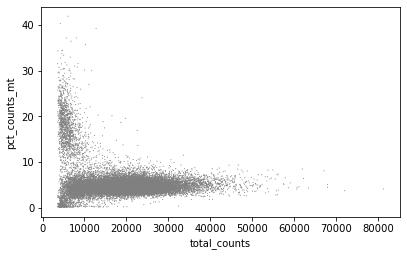

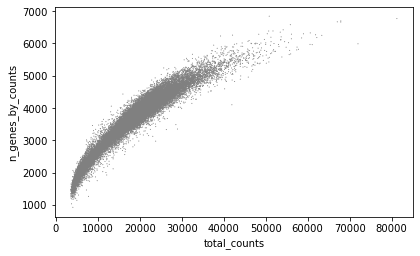

In [10]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')


In [11]:
adata = adata[adata.obs.pct_counts_mt < 10, :]

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [12]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [13]:
cell_cycle_genes = [x.strip() for x in open('./regev_lab_cell_cycle_genes.txt')]

s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

In [14]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'phase' as categorical


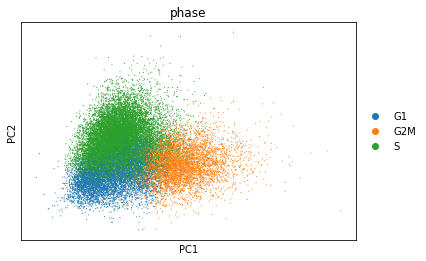

In [15]:
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

In [16]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


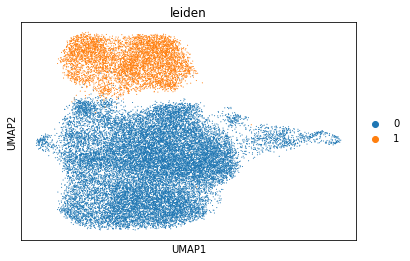

In [18]:
sc.tl.leiden(adata, resolution=0.05)
sc.pl.umap(adata, color=['leiden'])

In [19]:
# Reconstruct the raw but filtered AnnData object
adata_raw = sc.read(data_path + 'h5ad/raw-perturbseq.h5ad')
adata_raw = adata_raw[adata.obs.index, :]
adata_raw.obs = adata.obs.copy()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [20]:
adata_raw.write(data_path + 'h5ad/filtered-tf-perturbseq.h5ad')

### Assemble the K562 cell cycle inhibitor dataset

In [5]:
genes = pd.read_csv(
    data_path + 'h5ad/cell_cycle/GSM2396861_k562_ccycle_genenames.csv', index_col=0)
var_df = pd.DataFrame(index=genes['0'].str.split('_').str[1])
var_df['gene_id'] = genes['0'].str.split('_').str[0].tolist()

In [6]:
cells = pd.read_csv(
    data_path + 'h5ad/cell_cycle/GSM2396861_k562_ccycle_cellnames.csv', index_col=0)
obs_df = pd.DataFrame(index=cells['0'])
obs_df['cell'] = cells['0'].tolist()

In [7]:
mapping = pd.read_csv(data_path + '/h5ad/cell_cycle/GSM2396861_k562_ccycle_cbc_gbc_dict.csv', header=None)
mapping['cell'] = mapping[1].str.split(', ')
mapping = mapping.explode(column='cell').rename(columns={0:'guide'})[['cell', 'guide']]
guides = mapping['guide'].drop_duplicates().tolist()

In [8]:
print(obs_df.shape)
obs_df = obs_df.merge(mapping, on='cell', how='left').astype(str)
obs_df = pd.DataFrame(obs_df.groupby('cell').guide.apply(list))
obs_df['guides'] = obs_df['guide'].apply(lambda x: '-'.join(x))
print(obs_df.shape)

for g in guides:
    
    obs_df[g] = obs_df['guide'].str.contains(g)

(25971, 1)
(25971, 2)


In [9]:
X = io.mmread(data_path + '/h5ad/cell_cycle/GSM2396861_k562_ccycle.mtx.txt').tocsr()

In [10]:
adata = sc.AnnData(X=X.T.tocsc(), obs=obs_df, var=var_df)
adata.write(data_path + '/h5ad/raw-cellcycle.h5ad')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'guide' as categorical
... storing 'guides' as categorical


### Assemble the K562 cell cycle inhibitor dataset

In [11]:
adata = sc.read(data_path + 'h5ad/raw-cellcycle.h5ad')
adata.var_names_make_unique()
adata = adata[adata.obs['guides']!='nan', :].copy()
adata.obs['KO'] = (~adata.obs['guides'].str.contains('INTER')).astype(int)
adata.obs['WT'] = (adata.obs['guides'].str.contains('INTER'))
adata.obs['KO_GENE'] = adata.obs['guides'].str.split('_').str[1].str[2:]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [12]:
adata.obs['n_counts'] = adata.X.sum(axis=1)

In [13]:
guides = adata.obs.guides.drop_duplicates().tolist()
guides = [g for g in guides if ('INTER' not in g and 'nan' not in g)]
ko_genes = adata.obs.query('KO == 1')['KO_GENE'].drop_duplicates().tolist()

In [14]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [15]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


... storing 'KO_GENE' as categorical


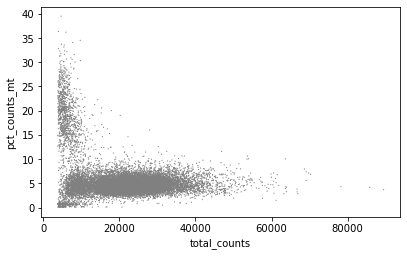

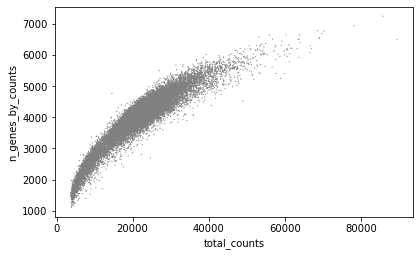

In [16]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')


In [17]:
adata = adata[adata.obs.pct_counts_mt < 10, :]

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [18]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [19]:
cell_cycle_genes = [x.strip() for x in open('./regev_lab_cell_cycle_genes.txt')]

s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

In [20]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'phase' as categorical


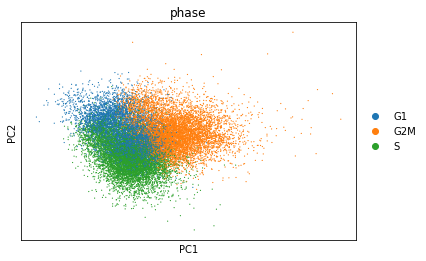

In [21]:
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'phase' as categorical


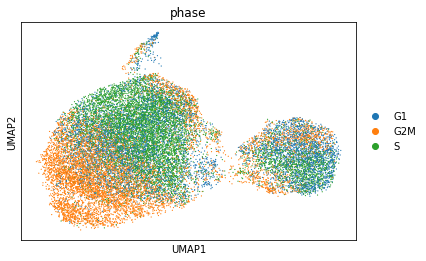

In [22]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color='phase')


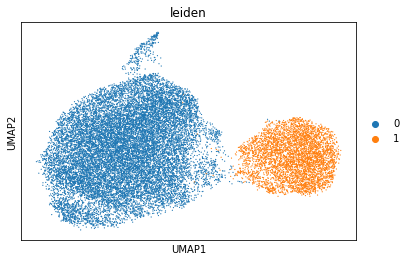

In [23]:
sc.tl.leiden(adata, resolution=0.05)
sc.pl.umap(adata, color=['leiden'])


In [24]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


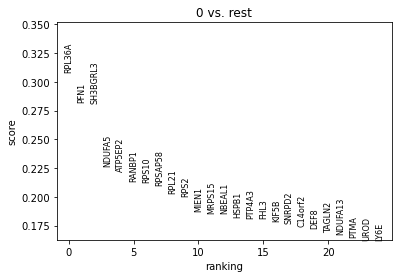

In [25]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)


In [26]:
# Reconstruct the raw but filtered AnnData object
adata_raw = sc.read(data_path + 'h5ad/raw-cellcycle.h5ad')
adata_raw = adata_raw[adata.obs.index, :]
adata_raw.obs = adata.obs.copy()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [27]:
adata_raw.write(data_path + 'h5ad/filtered-cellcycle.h5ad')